In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')

from axia.data_handler import DataHandler
from axia.shifted_beta_geometric import ShiftedBetaGeometric
from axia.sbg_survival import SBGSurvival

In [3]:
sys.path.append("./")
import util
from importlib import reload

# Data: Load, Preprocess, and Split

In [4]:
def _top_5_countries(c):
    if c in ['United States', 'Canada', 'United Kingdom', 'Australia', 'New Zealand']:
        return c.lower().replace(" ", "_")
    return "other_country"


def _top_20_crm_industries(c):
    if c in ['Lawn Care & Lawn Maintenance', 'Other', 'Residential Cleaning',
       'Construction & Contracting', 'HVAC', 'Landscaping Contractor',
       'Plumbing', 'Electrical Contractor', 'Commercial Cleaning',
       'Arborist / Tree Care', 'Pest Control', 'Window Washing', 'Handyman',
       'Pressure Washing Service', 'Pool and Spa Service', 'Renovations',
       'Painting', 'Computers & IT', 'Carpet Cleaning', 'Mechanical Service']:
        return c.lower().replace(" ", "_")
    return "other_industry"


def _end_date(dt):
    if pd.isnull(dt):
        return dt
    return dt.strftime("%Y-%m-01")

In [5]:
ltv = pd.read_csv("../data/ltv_per_customer-2019-02-15-19-52-31.csv", index_col=["account_id"])
# df = pd.read_csv("../data/master_dataset-2019-02-19-14-29-24.csv", parse_dates=["first_paying_date", "last_churn_date"])
df = pd.read_csv("../data/JOBBER_master_dataset_with_billing_freq-_2019-02-28.csv", parse_dates=["first_paying_date", "last_churn_date"])

df = df.drop_duplicates()
df.set_index("account_id", inplace=True)
df = df.dropna(how="all", subset=["initial_subscription_amt", "current_subscription_amt"])

irrelevant_cols = [
    'attr_channel_category_v1',
    'attr_channel_v1', 'heard_about_us', 'heard_about_us_category',
    'heard_about_us_sub_category', 'hdyhau_channel',
    'hdyhau_channel_category', 'utmz_channel_category', 'utmz_channel',
    'lifecycle_state', 'account_created_month', 'first_paying_month',
]
df.drop(irrelevant_cols, axis=1, inplace=True)

df = df.join(ltv.drop("lifecycle_state", axis=1))
df = df.fillna({'paying_months': 0, 'tot_revenue': 0})
df.rename(
    columns={
        "crm_industry": "industry",
        "initial_billing_frequency": "frequency",
    },
    inplace=True
)

df = df[df['frequency'] != "Unknown"]

df = df.sample(n=100, random_state=7)

In [6]:
%%time
reload(util)
data = util.SubscriptionData(
    data=df,
    start_date_col="first_paying_date",
    end_date_col="last_churn_date",
    subscription_initial="initial_subscription_amt",
    subscription_current="current_subscription_amt",
    additional_cols=[
        df["country"].apply(_top_5_countries).astype("category"),
        df["industry"].apply(_top_20_crm_industries).astype("category"),
        df["frequency"].astype("category"),
    ]
)

CPU times: user 1.49 s, sys: 8 ms, total: 1.5 s
Wall time: 1.49 s


In [11]:
from datetime import datetime

In [17]:
data.cdf.loc[15432].head()

,start_date,end_date,age,alive,is_starting_month,is_cancelation_month,months_alive,subscription_value,value_to_date
end_of_month,,,,,,,,,
2015-06-30,2015-06-01,NaT,0,0,1,0,0,58.000000,58.000000
2015-07-31,2015-06-01,NaT,1,1,0,0,1,57.568182,115.568182
2015-08-31,2015-06-01,NaT,2,1,0,0,2,57.136364,172.704545
2015-09-30,2015-06-01,NaT,3,1,0,0,3,56.704545,229.409091
2015-10-31,2015-06-01,NaT,4,1,0,0,4,56.272727,285.681818


In [222]:
data.df.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,country,industry,frequency
account_id,,,,,,,,,,
2,2011-04-01,NaT,94,1,65.0,128.0,128.0,canada,painting,monthly
34,2012-04-01,NaT,82,1,47.0,47.0,47.0,canada,arborist_/_tree_care,monthly
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,united_states,lawn_care_&_lawn_maintenance,monthly
109,2011-05-01,NaT,93,1,38.0,47.0,47.0,canada,painting,monthly
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,united_states,mechanical_service,monthly


# Actuals

In [182]:
data.cdf.head()

start_date end_date  age  alive  is_starting_month  \
account_id end_of_month                                                      
2          2011-04-30   2011-04-01      NaT    0      0                  1   
           2011-05-31   2011-04-01      NaT    1      1                  0   
           2011-06-30   2011-04-01      NaT    2      1                  0   
           2011-07-31   2011-04-01      NaT    3      1                  0   
           2011-08-31   2011-04-01      NaT    4      1                  0   

                         is_cancelation_month  months_alive  \
account_id end_of_month                                       
2          2011-04-30                       0             0   
           2011-05-31                       0             1   
           2011-06-30                       0             2   
           2011-07-31                       0             3   
           2011-08-31                       0             4   

                         subscription_value  value_to_date  
account_id end_of_month                                     
2          2011-04-30             65.000000      65.000000  
           2011-05-31             65.670213     130.670213  
           2011-06-30             66.340426     197.010638  
           2011-07-31             67.010638     264.021277  
           2011-08-31             67.680851     331.702128

In [183]:
(
    data.cdf
    .query("age == 11")
    [["alive", "subscription_value", "value_to_date"]]
    .describe(percentiles=[0.1, 0.5, 0.9])
    .loc[["mean", "10%", "50%", "90%"]]
)

,alive,subscription_value,value_to_date
mean,0.715471,55.905313,759.904809
10%,0.000000,0.000000,179.100000
50%,1.000000,53.000000,683.651136
90%,1.000000,121.062069,1404.514286


In [184]:
def _months_alive(df):
    df["months_alive"] = df.groupby(df.index.get_level_values("account_id")).agg({"alive": "cumsum"})
    return df

year_1_stats = (
    data.cdf
    .pipe(_months_alive)
    .query("age == 11")
    .groupby("start_date")
    .agg({
        "age": "count",
        "alive": "mean",
        "months_alive": "mean",
        "subscription_value": "mean",
        "value_to_date": "mean",
    })
    .loc["2014-01-01":]
    .rolling(window=6)
    .mean()
)
year_1_stats.tail()

,age,alive,months_alive,subscription_value,value_to_date
start_date,,,,,
2017-11-01,297.666667,0.703796,8.741931,69.901403,958.885387
2017-12-01,284.500000,0.705850,8.730328,76.285301,1040.567014
2018-01-01,289.500000,0.703280,8.711383,81.766400,1113.959421
2018-02-01,295.500000,0.700546,8.663012,86.564792,1178.327101
2018-03-01,325.833333,0.693757,8.621013,90.218962,1231.352359


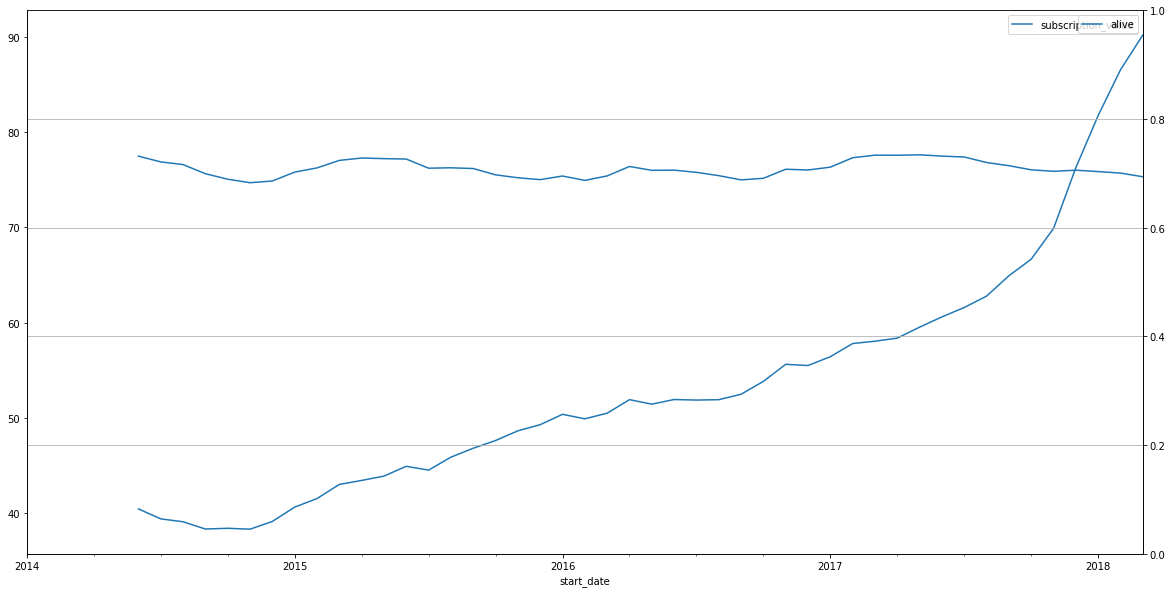

In [185]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

year_1_stats[["alive"]].plot(ax=ax2)
year_1_stats[["subscription_value"]].plot(ax=ax1)

ax2.set_ybound((0, 1))
# ax1.grid(True)
ax2.grid(True)

# Traditional

,avg_subscription_value,avg_arpu_6m,churn_rate,avg_churn_6m
end_of_month,,,,
2018-09-30,99.520029,97.345033,0.023798,0.023522
2018-10-31,101.694328,98.505685,0.024348,0.023111
2018-11-30,102.289351,99.629628,0.026703,0.023824
2018-12-31,102.933052,100.677650,0.022665,0.024169
2019-01-31,104.770602,101.846859,0.027042,0.024929
2019-02-28,105.731897,102.823210,0.024656,0.024869


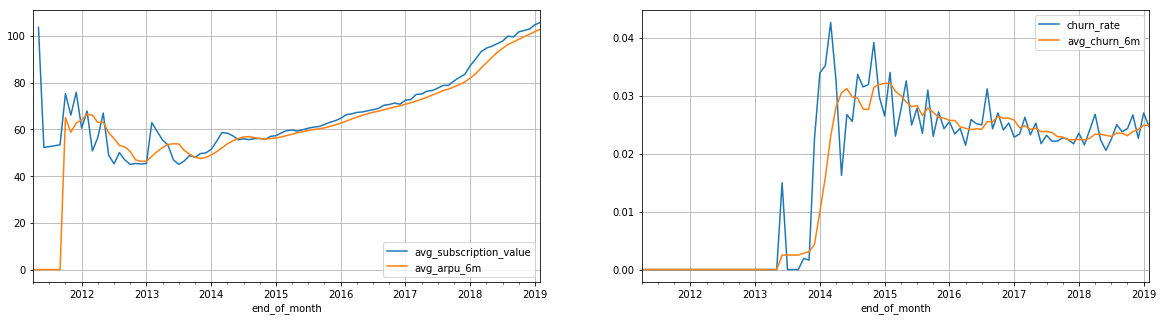

In [282]:
def _churn_rate(df):
    df["churn_rate"] = (df["is_cancelation_month"] / df["alive"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df


def _arpu_progression(df):
    df["subscription_value"] = df["subscription_value"] / df["alive"]
    df["avg_arpu_6m"] = df["subscription_value"].rolling(window=6).mean().fillna(0)
    df = df.rename(columns={"subscription_value": "avg_subscription_value"})
    return df

cdf = (
    data.cdf
    .groupby("end_of_month")
    .agg({
        'alive': "sum",
        "is_starting_month": 'sum',
        'is_cancelation_month': 'sum',
        "subscription_value": "sum",
    })
    .pipe(_arpu_progression)
    .pipe(_churn_rate)
    [["avg_subscription_value", "avg_arpu_6m", "churn_rate", "avg_churn_6m"]]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
cdf.plot(y=["churn_rate", "avg_churn_6m"], ax=ax[1])
cdf.plot(y=["avg_subscription_value", "avg_arpu_6m"], ax=ax[0])
for axis in ax:
    axis.grid(True)
cdf.tail(6)

In [187]:
sum([data.df[data.df["alive"] > 0]["subscription_current"].mean() * (1 - 0.025065) ** m for m in range(12)])

1060.2461416007866

# SBG

In [227]:
def _increase_age_floor(df):
    d = df.copy()
    d["age"] = np.maximum(df["age"], 1)
    return d

In [192]:
sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=["country", "industry", "frequency"],
    gamma=1e-3,
    verbose=False
)

In [231]:
%time sbg.fit(data.dtr[data.dtr["start_date"] < "2019-01-01"].pipe(_increase_age_floor))

CPU times: user 1min 5s, sys: 115 ms, total: 1min 6s
Wall time: 1min 6s


In [239]:
retention = sbg.predict_survival(data.dva, age=1, n_periods=13)

probability    10.525010
traditional    11.213843
alive          10.578200
dtype: float64

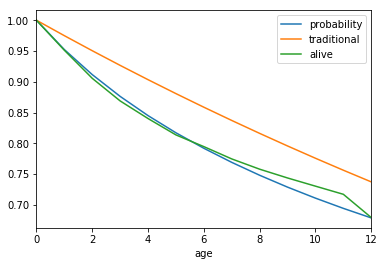

In [280]:
test = retention.groupby(retention.index.get_level_values("age")).mean()
test['traditional'] = [(1 - 0.025065) ** m for m in range(13)]
test = test.join((
    data.cdva
    .query("age <= 12")
    .join(data.cdva.query("age == 12").reset_index(level=1)[[]], how="inner")
    .groupby("age")
    .agg({"alive": "mean"})
))
test.loc[0, "alive"] = 1

test.plot()
test.sum()

             frequency
probability  annual       11.865027
             monthly      10.238674
alive        annual       12.280987
             monthly      10.197752
dtype: float64

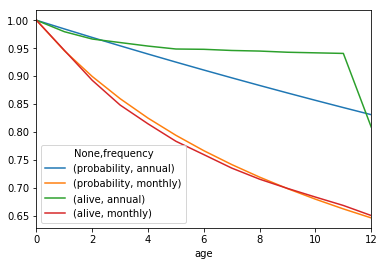

In [281]:
test = (
    retention
    .join(data.dva[["frequency"]])
    .reset_index('age')
    .groupby(["age", "frequency"])
    .agg({"probability": "mean"})
    .unstack()
)
# test['traditional'] = [(1 - 0.025065) ** m for m in range(13)]
test = test.join((
    data.cdtr
    .join(data.dtr[["frequency"]], how="inner")
    .query("age <= 12")
    .join(data.cdtr.query("age == 12").reset_index(level=1)[[]], how="inner")
    .groupby(["age", "frequency"])
    .agg({"alive": "mean"})
    .unstack()
))
test.loc[0] = 1

test.plot()
test.sum()

In [294]:
def _expected_value_to_date(df):
    d = df.copy()
    d["expected_payment"] = d["probability"] * d["subscription_initial"]
    d["expected_value_to_date"] = (
        d
        .groupby(d.index.get_level_values("account_id"))
        .agg({"expected_payment": "cumsum"})
    )
    return d

(
    retention
    .join(data.dva["subscription_initial"])
    .pipe(_expected_value_to_date)
    .reset_index("age")
    .query("age == 11")
    .describe(percentiles=[0.1, 0.5, 0.9])
    .loc[["mean", "10%", "50%", "90%"]]
)

,age,probability,subscription_initial,expected_payment,expected_value_to_date
mean,11.0,0.694394,86.802731,59.755572,850.381116
10%,11.0,0.583881,39.000000,27.430635,388.238086
50%,11.0,0.673524,77.000000,51.523071,737.263578
90%,11.0,0.846587,145.000000,102.954714,1416.916321
